STEP1.문제정의

서비스 A(2021.12.01 ~ 2021.12.31)와 서비스 B(2022.03.01 ~ 2022.03.31)의 일별 매출을 예측하시오.

In [63]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pylab import rcParams

from sklearn import preprocessing
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fbprophet import Prophet

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import Series, DataFrame

In [3]:
#STEP2. Data Collection(데이터 수집)

#import dataset
service_A=pd.read_csv("D:\kakaotech\service_A.csv",encoding='UTF8')
service_B=pd.read_csv("D:\kakaotech\service_B.csv",encoding='UTF8')

print('서비스 A: ',service_A.shape , '\n서비스 B: ', service_B.shape)

서비스 A:  (1065, 9) 
서비스 B:  (790, 9)


In [4]:
service_A.head(5)

,Unnamed: 0,날짜,feat_a,feat_b,feat_c,feat_d,feat_e,feat_f,매출
0,0,2021. 11. 30,30480660,100048,3275,319,3995,4667050,27293784
1,1,2021. 11. 29,29593770,95950,6697,308,3834,4530980,25066031
2,2,2021. 11. 28,19918007,86572,7129,304,3667,3584937,22762015
3,3,2021. 11. 27,20090058,85331,1825,312,3452,3896014,22723865
4,4,2021. 11. 26,28273300,94126,6574,327,3898,7075691,23686756


In [5]:
#STEP3. Data Exploration & Data Preprocessing(데이터 탐색 및 전처리 )
#STEP3-1. 데이터 탐색
service_A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1065 non-null   int64 
 1   날짜          1065 non-null   object
 2   feat_a      1065 non-null   int64 
 3   feat_b      1065 non-null   int64 
 4   feat_c      1065 non-null   int64 
 5   feat_d      1065 non-null   int64 
 6   feat_e      1065 non-null   int64 
 7   feat_f      1065 non-null   int64 
 8   매출          1065 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 75.0+ KB


In [6]:
temp_A=service_A.drop('Unnamed: 0', axis=1)
temp_A

,날짜,feat_a,feat_b,feat_c,feat_d,feat_e,feat_f,매출
0,2021. 11. 30,30480660,100048,3275,319,3995,4667050,27293784
1,2021. 11. 29,29593770,95950,6697,308,3834,4530980,25066031
2,2021. 11. 28,19918007,86572,7129,304,3667,3584937,22762015
3,2021. 11. 27,20090058,85331,1825,312,3452,3896014,22723865
4,2021. 11. 26,28273300,94126,6574,327,3898,7075691,23686756
...,...,...,...,...,...,...,...,...
1060,2019. 1. 5,16547256,75180,7502,230,1705,2578383,14697297
1061,2019. 1. 4,21885288,82317,8182,239,1837,2411262,17257373
1062,2019. 1. 3,20386487,78938,437,244,1363,2488056,16796881
1063,2019. 1. 2,19226542,79779,8699,238,1420,1995960,17013518


<AxesSubplot:xlabel='date', ylabel='매출'>

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)


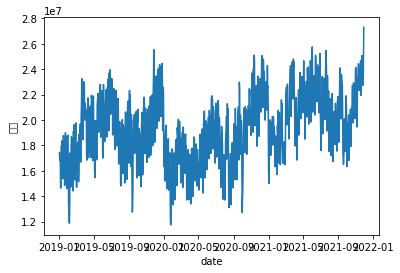

In [7]:
temp_A['date']=pd.to_datetime(temp_A['날짜'])

sns.lineplot(data=temp_A, x='date', y='매출', estimator=sum)

In [8]:
df=pd.pivot_table(data=temp_A, index='date', values='매출', aggfunc='sum').reset_index()
df

,date,매출
0,2019-01-01,17425701
1,2019-01-02,17013518
2,2019-01-03,16796881
3,2019-01-04,17257373
4,2019-01-05,14697297
...,...,...
1060,2021-11-26,23686756
1061,2021-11-27,22723865
1062,2021-11-28,22762015
1063,2021-11-29,25066031


In [52]:
#STEP3-2. missing value: dropna를 사용하여 결측값이 있는 행을 제거.
df_A=temp_A.dropna()

In [53]:
#STEP4. Modeling

#STEP4-1. dickey-fuller 단위근 검정으로 일일 매출의 정상성 여부를 점검
result=adfuller(df_A['매출'])
print(result)

(-3.5569383043253895, 0.006639693478928581, 21, 1043, {'1%': -3.436635203238866, '5%': -2.8643150683130307, '10%': -2.568247558190521}, 31947.673164622098)


result[0]은 Dickey-Fuller 단위근 검정통계량을, result[1]=0.0066은 p-value이다. 이때 p-value가 0.05보다 작으므로 귀무가설을 기각한다. 즉, 일일 매출은 정상성을 나타내고 있으므로 장기적으로 예측할 수 있는 패턴의 데이터는 아닐 것이라 생각했습니다. 

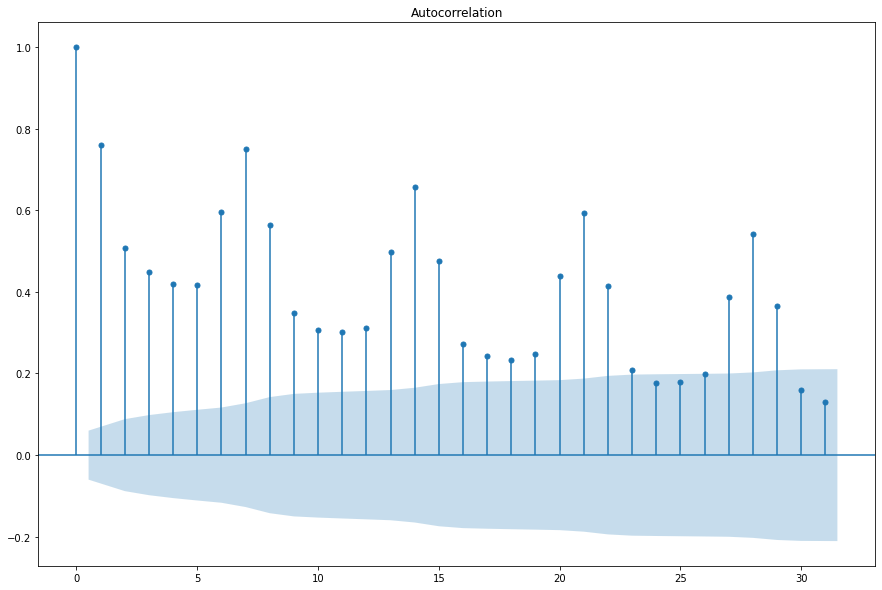

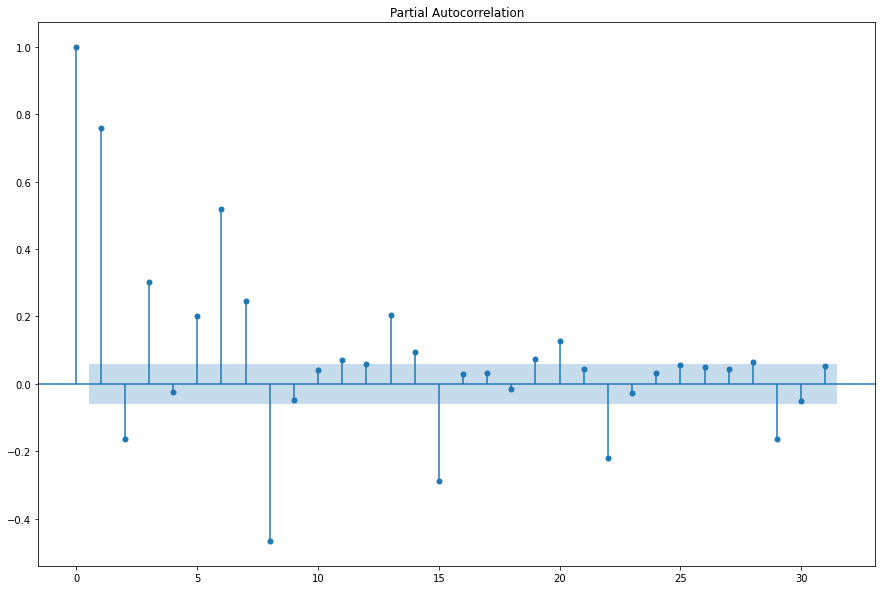

In [54]:
plot_acf(df_A['매출'])
plot_pacf(df_A['매출'])
plt.show()

In [55]:
#STEP4-2.ARIMA
df2_A=pd.pivot_table(data=df, index='date', values='매출', aggfunc='sum')

df2_A.head()

,매출
date,
2019-01-01,17425701
2019-01-02,17013518
2019-01-03,16796881
2019-01-04,17257373
2019-01-05,14697297


In [56]:
y=df2_A['매출'].resample('1D').mean()

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)


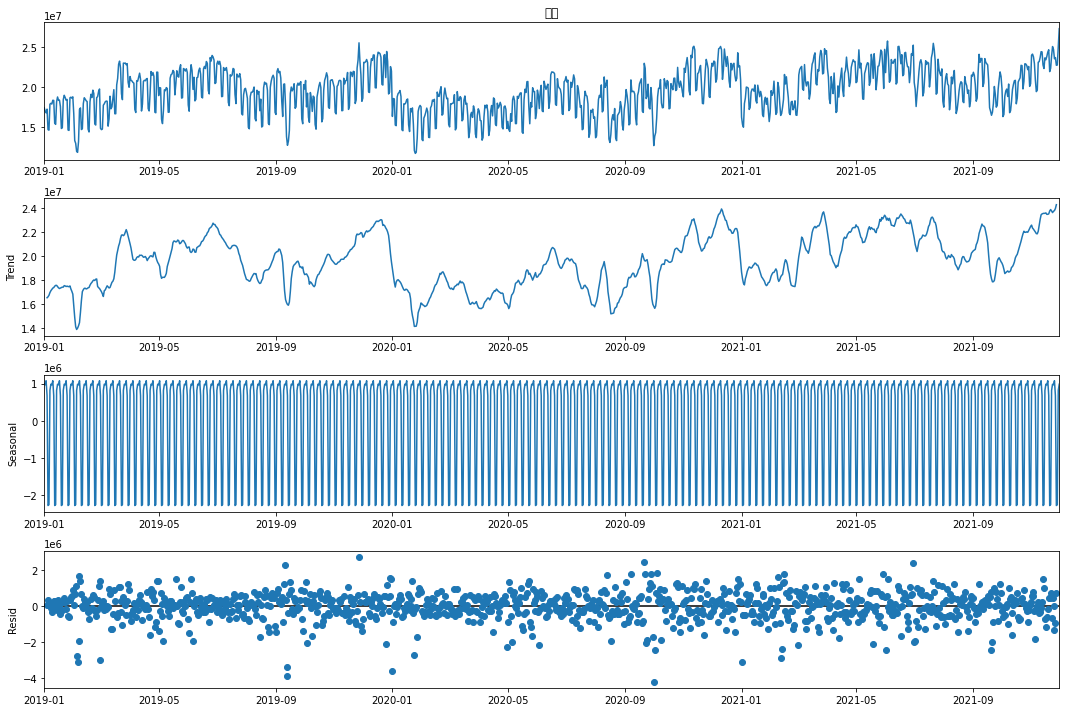

In [57]:
#시계열 모델 plot 

rcParams['figure.figsize']=15,10

model_series=tsa.seasonal_decompose (y, model='additive')
fig=model_series.plot()

plt.show()

In [77]:
#ARIMA
model_arima=tsa.statespace.SARIMAX(y, order=(0,1,1),seasonal_order=(0,1,1,12),
                                                enforce_stationarity=False, enforce_invertibility=False)
result_arima=model_arima.fit()

print(result_arima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0856      0.091      0.936      0.349      -0.094       0.265
ma.S.L12      -0.8714      0.017    -51.390      0.000      -0.905      -0.838
sigma2      1.008e+13   1.33e-15   7.59e+27      0.000    1.01e+13    1.01e+13


In [69]:
ar_p=ma_q=d=range(0,2)
pqd=list(itertools.product(ar_p, d, ma_q))
seasonal_pqd=[(x[0], x[1], x[2], 12) for x in list(itertools.product(ar_p, d, ma_q))]

seasonal_pqd #ARIMA model parameters

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [70]:
param_list=[]
param_seasonal_list=[]
result_list=[]

In [78]:
for param in pqd:
    for param_seasonal in seasonal_pqd:
        try:
            model_sa=tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal,
                                                enforce_stationarity=False, enforce_invertibility=False)
            results=model_sa.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            result_list.append(results.aic)
        except:
            continue

In [79]:
arima_list=pd.DataFrame({'Parameter': param_list, 'Seasonal': param_seasonal_list, 'AIC': result_list})
arima_list.to_csv('ARIMA Model_A.csv')

In [80]:
arima_list.sort_values(by='AIC')

,Parameter,Seasonal,AIC
121,"(1, 1, 1)","(0, 0, 1, 12)",33070.015959
57,"(1, 1, 1)","(0, 0, 1, 12)",33070.015959
47,"(1, 0, 1)","(1, 1, 1, 12)",33141.664657
111,"(1, 0, 1)","(1, 1, 1, 12)",33141.664657
125,"(1, 1, 1)","(1, 0, 1, 12)",33167.489648
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 12)",37624.319849
8,"(0, 0, 1)","(0, 0, 0, 12)",37956.670032
72,"(0, 0, 1)","(0, 0, 0, 12)",37956.670032
64,"(0, 0, 0)","(0, 0, 0, 12)",38772.734939


In [81]:
model_sarimax=tsa.statespace.SARIMAX(y, order=(1,1,1), seasonal_order=(0,0,1,12), enforce_stationarity=False, enforcce_invertibilty=False)
result_sarimax=model_sarimax.fit()

print(result_sarimax.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 매출   No. Observations:                 1065
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 12)   Log Likelihood              -16531.008
Date:                            Mon, 16 May 2022   AIC                          33070.016
Time:                                    16:53:35   BIC                          33089.842
Sample:                                01-01-2019   HQIC                         33077.533
                                     - 11-30-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5050      0.051      9.959      0.000       0.406       0.604
ma.L1         -0.8464      0.031   

In [82]:
forecast_result=result_sarimax.forecast(steps=31)
print(forecast_result)

2021-12-01    2.585141e+07
2021-12-02    2.570450e+07
2021-12-03    2.527890e+07
2021-12-04    2.420821e+07
2021-12-05    2.358558e+07
2021-12-06    2.368832e+07
2021-12-07    2.415774e+07
2021-12-08    2.414624e+07
2021-12-09    2.432263e+07
2021-12-10    2.453382e+07
2021-12-11    2.353683e+07
2021-12-12    2.244831e+07
2021-12-13    2.305481e+07
2021-12-14    2.336110e+07
2021-12-15    2.351578e+07
2021-12-16    2.359390e+07
2021-12-17    2.363335e+07
2021-12-18    2.365328e+07
2021-12-19    2.366334e+07
2021-12-20    2.366842e+07
2021-12-21    2.367099e+07
2021-12-22    2.367228e+07
2021-12-23    2.367294e+07
2021-12-24    2.367327e+07
2021-12-25    2.367344e+07
2021-12-26    2.367352e+07
2021-12-27    2.367356e+07
2021-12-28    2.367358e+07
2021-12-29    2.367360e+07
2021-12-30    2.367360e+07
2021-12-31    2.367360e+07
Freq: D, Name: predicted_mean, dtype: float64


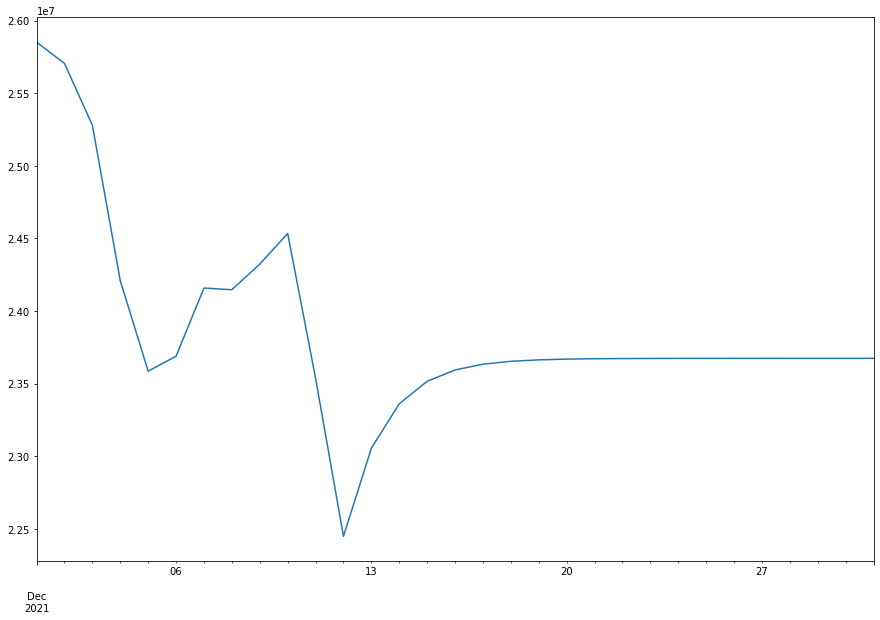

In [83]:
fore_plt=forecast_result.plot()

plt.show()

In [84]:
forecast_result.to_csv('Service_A_predict.csv')

In [108]:
#STEP5. Model 성능 확인
df2_A['forecast']=result_sarimax.predict(start=50, end=200)

<AxesSubplot:xlabel='date'>

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0, flags=flags)


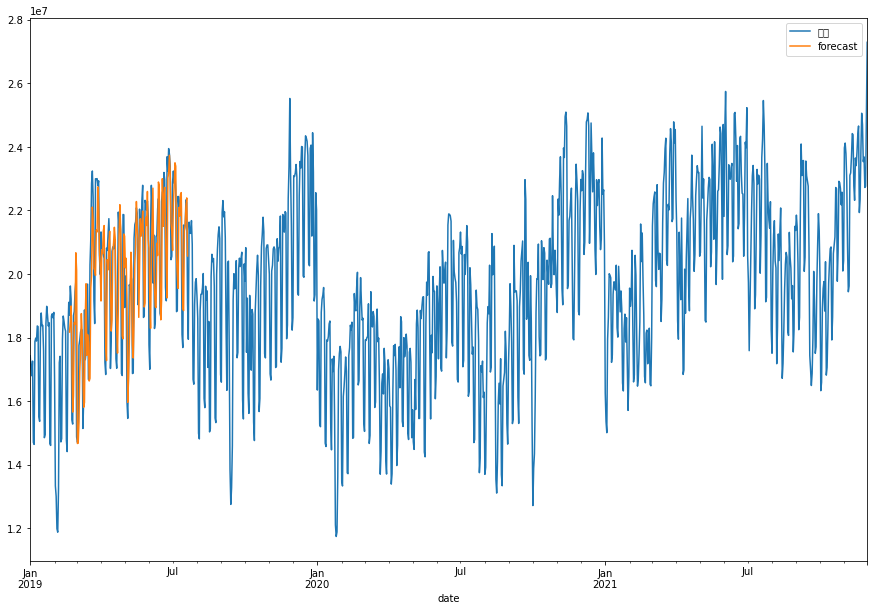

In [109]:
df2_A[['매출', 'forecast']].plot()

C:\Users\user\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0, flags=flags)


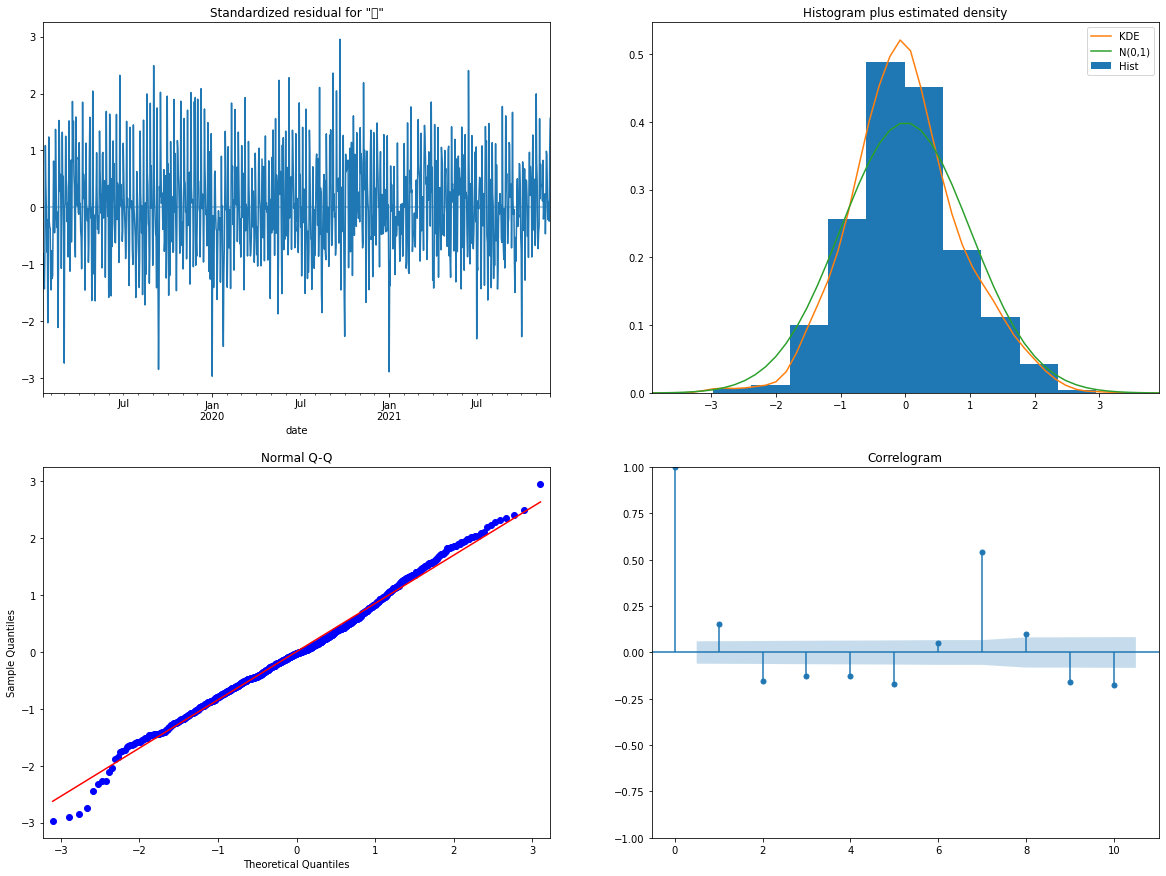

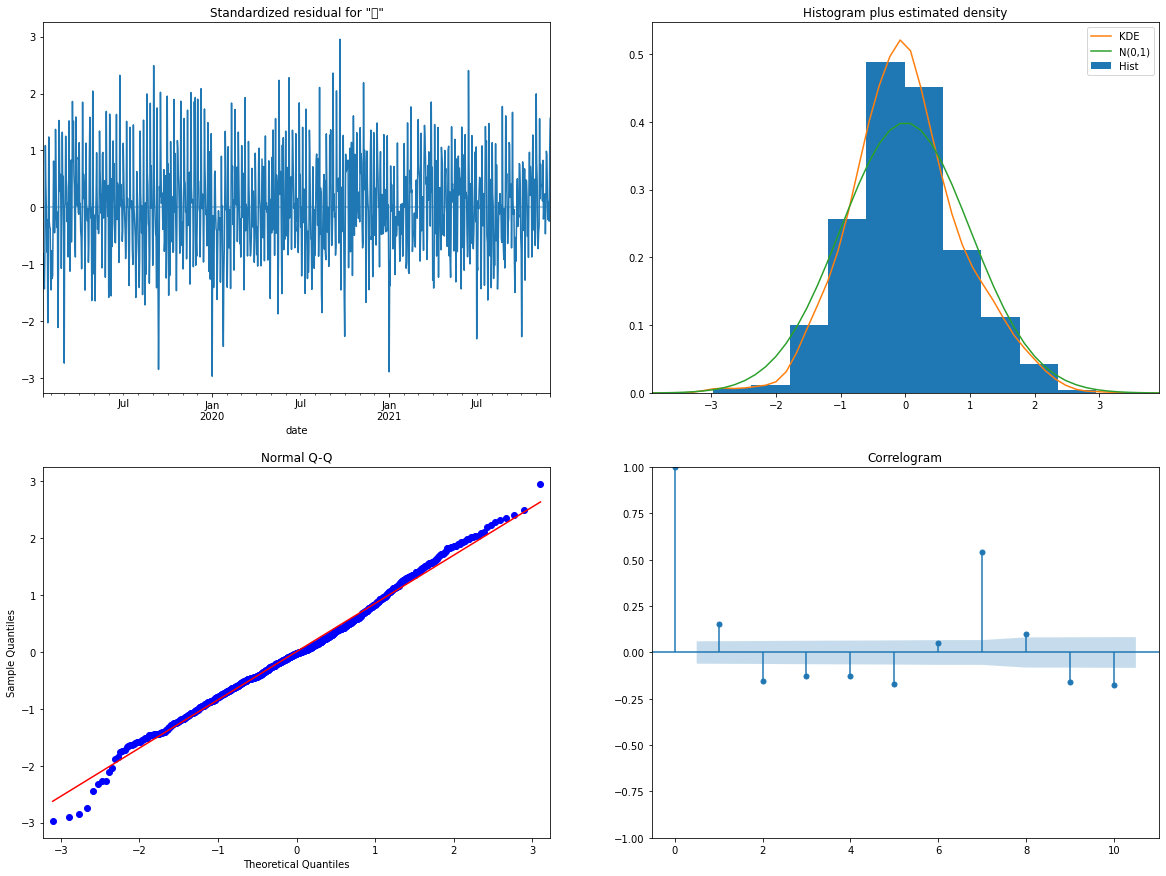

In [114]:
rcParams['figure.figsize']=20,15

result_sarimax.plot_diagnostics()